In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams["figure.figsize"] = (12,4)

PROJECT_ROOT = os.getcwd()
DATA_PATH = os.path.join(PROJECT_ROOT, "data", "household_power_consumption.txt")
OUT = os.path.join(PROJECT_ROOT, "notebooks_output")
os.makedirs(OUT, exist_ok=True)

print("Project root:", PROJECT_ROOT)
print("Dataset exists:", os.path.exists(DATA_PATH))
print("Dataset size (MB):", round(os.path.getsize(DATA_PATH)/(1024*1024),2))


Project root: C:\Users\feba thankam moni\Desktop\energyproject
Dataset exists: True
Dataset size (MB): 126.8


In [4]:
# CELL 2 — Load the dataset and show a preview
import pandas as pd
DATA_PATH = "data/household_power_consumption.txt"

df = pd.read_csv(
    DATA_PATH,
    sep=";",
    na_values=["?"],
    low_memory=False
)

print("Raw shape:", df.shape)
display(df.head(8))


Raw shape: (2075259, 9)


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
5,16/12/2006,17:29:00,3.520,0.522,235.02,15.0,0.0,2.0,17.0
6,16/12/2006,17:30:00,3.702,0.520,235.09,15.8,0.0,1.0,17.0
7,16/12/2006,17:31:00,3.700,0.520,235.22,15.8,0.0,1.0,17.0


In [5]:
# CELL 3 — Convert Date + Time to datetime & clean

# 1. Convert Date + Time → datetime
df["datetime"] = pd.to_datetime(
    df["Date"] + " " + df["Time"],
    dayfirst=True,
    errors="coerce"
)

print("Invalid datetime rows:", df["datetime"].isna().sum())

# 2. Drop rows with invalid datetime
df = df.dropna(subset=["datetime"]).copy()

# 3. Set datetime as index
df = df.set_index("datetime").sort_index()

# 4. Drop old Date & Time columns
df = df.drop(columns=["Date", "Time"])

# 5. Convert all remaining cols to numeric
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors="coerce")

print("\nAfter converting to datetime + numeric:")
display(df.head())
df.info()


Invalid datetime rows: 0

After converting to datetime + numeric:


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [6]:
# CELL 4 — Missing values & duplicates

print("Duplicate rows:", df.duplicated().sum())

print("\nMissing values per column:")
display(df.isna().sum())

print("\nMissing percentage per column:")
display((df.isna().mean() * 100).round(3))


Duplicate rows: 168560

Missing values per column:


Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64


Missing percentage per column:


Global_active_power      1.252
Global_reactive_power    1.252
Voltage                  1.252
Global_intensity         1.252
Sub_metering_1           1.252
Sub_metering_2           1.252
Sub_metering_3           1.252
dtype: float64

In [7]:
# Time gap summary
time_gaps = df.index.to_series().diff().dt.total_seconds().dropna()
print("\nTime gap summary (seconds):")
display(time_gaps.describe())



Time gap summary (seconds):


count    2075258.0
mean          60.0
std            0.0
min           60.0
25%           60.0
50%           60.0
75%           60.0
max           60.0
Name: datetime, dtype: float64

In [8]:
# CELL 5 — Resample minute-level data to hourly averages

hourly = df.resample("H").mean()

print("Hourly shape:", hourly.shape)
display(hourly.head())

# Save for reference
hourly.to_csv(os.path.join(OUT, "hourly_raw.csv"))


C:\Users\feba thankam moni\AppData\Local\Temp\ipykernel_16484\2719753363.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly = df.resample("H").mean()


Hourly shape: (34589, 7)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667


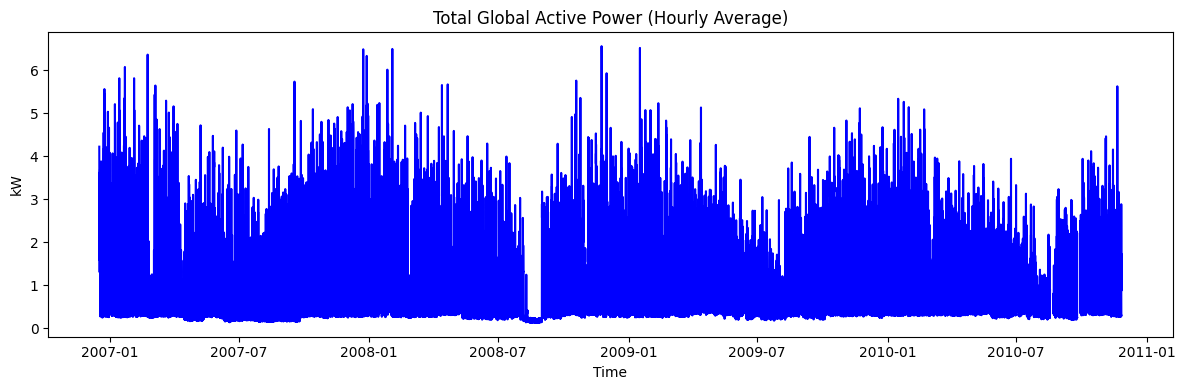

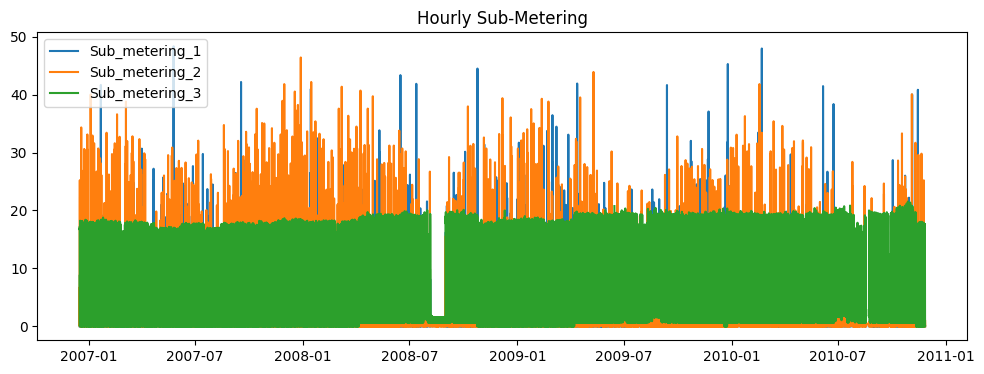

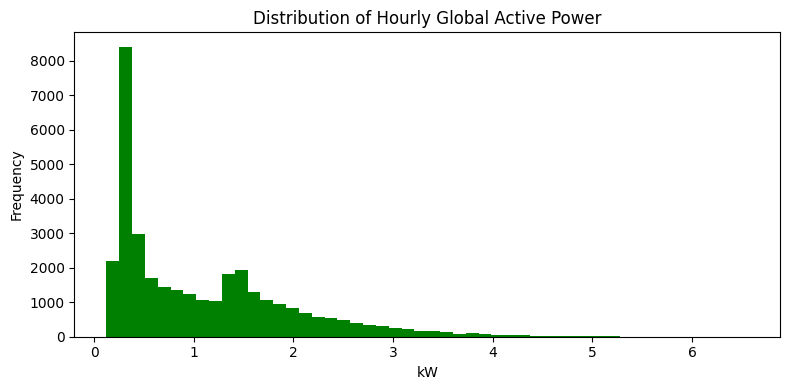

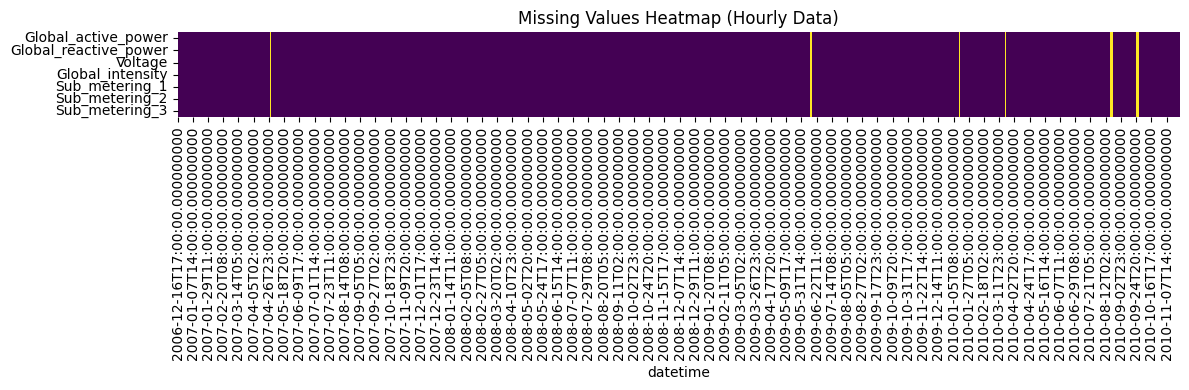

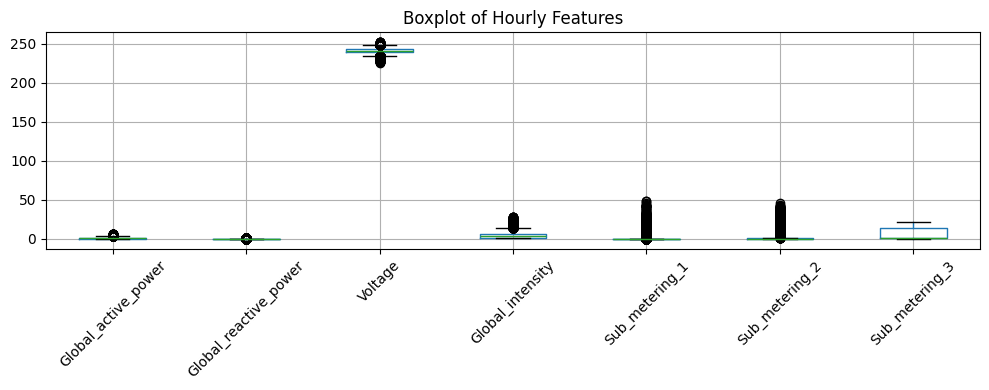

In [9]:
# CELL 6 — EDA PLOTS

### 1) Total hourly consumption (Global Active Power)
plt.figure(figsize=(12,4))
plt.plot(hourly["Global_active_power"], color="blue")
plt.title("Total Global Active Power (Hourly Average)")
plt.xlabel("Time")
plt.ylabel("kW")
plt.tight_layout()
plt.savefig(os.path.join(OUT, "total_hourly.png"))
plt.show()


### 2) Sub-metering Energy Usage
sub_cols = ["Sub_metering_1", "Sub_metering_2", "Sub_metering_3"]

plt.figure(figsize=(12,4))
for col in sub_cols:
    plt.plot(hourly[col], label=col)
plt.legend()
plt.title("Hourly Sub-Metering")
plt.savefig(os.path.join(OUT, "submetering_hourly.png"))
plt.show()


### 3) Distribution Plot (Histogram)
plt.figure(figsize=(8,4))
plt.hist(hourly["Global_active_power"].dropna(), bins=50, color="green")
plt.title("Distribution of Hourly Global Active Power")
plt.xlabel("kW")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig(os.path.join(OUT, "dist_hourly.png"))
plt.show()


### 4) Missing Values Heatmap
plt.figure(figsize=(12,4))
sns.heatmap(hourly.isna().T, cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap (Hourly Data)")
plt.tight_layout()
plt.savefig(os.path.join(OUT, "missing_heatmap_hourly.png"))
plt.show()


### 5) Boxplot (Outliers and spread)
plt.figure(figsize=(10,4))
hourly.boxplot()
plt.xticks(rotation=45)
plt.title("Boxplot of Hourly Features")
plt.tight_layout()
plt.savefig(os.path.join(OUT, "boxplot_hourly.png"))
plt.show()


In [10]:
# CELL 7 — Missing Value Filling Methods

### Method 1: Column Mean
filled_mean = hourly.fillna(hourly.mean())


### Method 2: Forward-fill then Back-fill
filled_ffill = hourly.fillna(method="ffill").fillna(method="bfill")


### Method 3: Time Interpolation
filled_interp = hourly.interpolate(method="time")


### Method 4: Hour-of-day Mean (BEST)
hourly_copy = hourly.copy()
hourly_copy["hour"] = hourly_copy.index.hour

hour_means = hourly_copy.groupby("hour").mean()

filled_hod = hourly.copy()

for hr in range(24):
    mask = filled_hod.index.hour == hr
    filled_hod.loc[mask] = filled_hod.loc[mask].fillna(hour_means.loc[hr])

# Save all filled versions
filled_mean.to_csv(os.path.join(OUT, "filled_mean.csv"))
filled_ffill.to_csv(os.path.join(OUT, "filled_ffill.csv"))
filled_interp.to_csv(os.path.join(OUT, "filled_interp.csv"))
filled_hod.to_csv(os.path.join(OUT, "filled_hod_best.csv"))

print("All missing-value strategies saved in notebooks_output/")


C:\Users\feba thankam moni\AppData\Local\Temp\ipykernel_16484\190707250.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filled_ffill = hourly.fillna(method="ffill").fillna(method="bfill")


All missing-value strategies saved in notebooks_output/


In [11]:
hourly.ffill()
hourly.bfill()


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667
...,...,...,...,...,...,...,...
2010-11-26 17:00:00,1.725900,0.061400,237.069667,7.216667,0.0,0.000000,12.866667
2010-11-26 18:00:00,1.573467,0.053700,237.531833,6.620000,0.0,0.000000,0.000000
2010-11-26 19:00:00,1.659333,0.060033,236.741000,7.056667,0.0,0.066667,0.000000


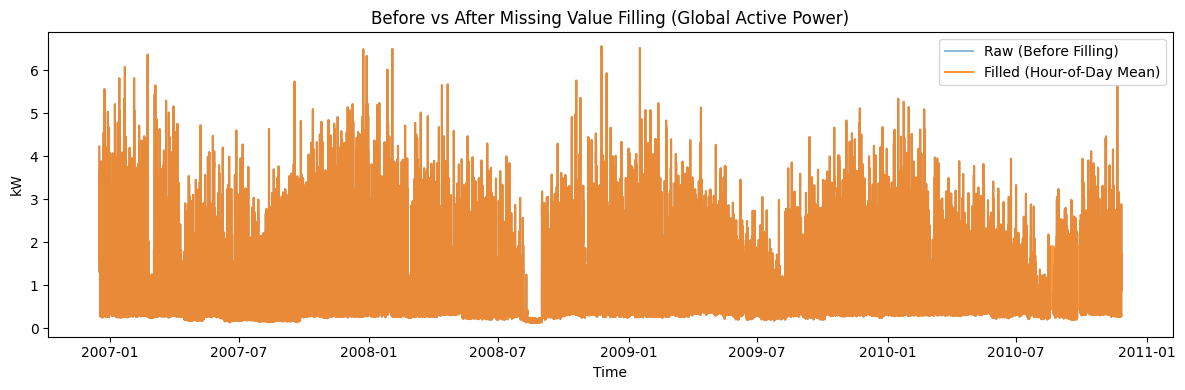

In [12]:
# CELL 8 — Before vs After (Global Active Power)

plt.figure(figsize=(12,4))
plt.plot(hourly["Global_active_power"], label="Raw (Before Filling)", alpha=0.5)
plt.plot(filled_hod["Global_active_power"], label="Filled (Hour-of-Day Mean)", alpha=0.8)
plt.title("Before vs After Missing Value Filling (Global Active Power)")
plt.xlabel("Time")
plt.ylabel("kW")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUT, "before_after_filling.png"))
plt.show()



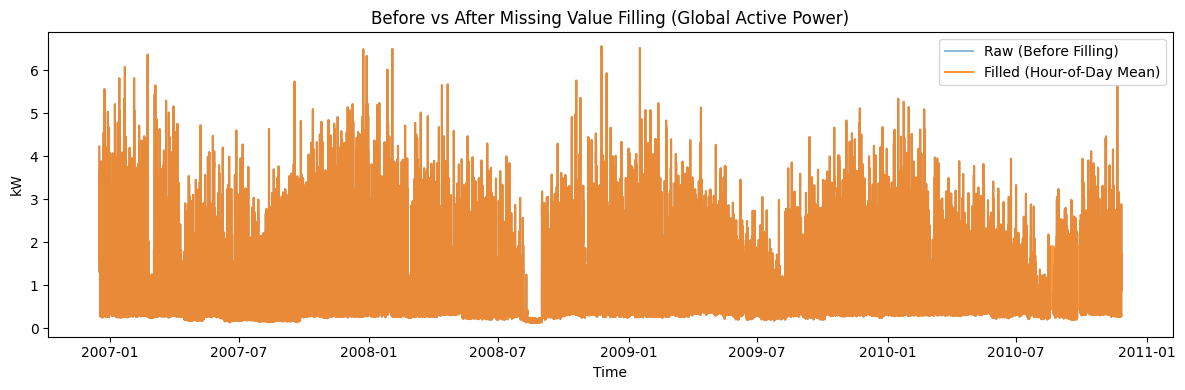

In [13]:
# CELL 8 — Before vs After (Global Active Power)

plt.figure(figsize=(12,4))
plt.plot(hourly["Global_active_power"], label="Raw (Before Filling)", alpha=0.5)
plt.plot(filled_hod["Global_active_power"], label="Filled (Hour-of-Day Mean)", alpha=0.8)
plt.title("Before vs After Missing Value Filling (Global Active Power)")
plt.xlabel("Time")
plt.ylabel("kW")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUT, "before_after_filling.png"))
plt.show()


In [14]:
# CELL 9 — Save final cleaned dataset
final_cleaned = filled_hod.copy()
final_cleaned.to_csv("data/final_cleaned_hourly_energy.csv")
print("Final cleaned dataset saved as data/final_cleaned_hourly_energy.csv")


Final cleaned dataset saved as data/final_cleaned_hourly_energy.csv
